## Plant Disease Prediction

In [1]:
# Set Parameters

# Samples per class in Traing Dataset
TRAIN_SAMPLES = 256

# Samples per class in Validation Dataset
VAL_SAMPLES = 64

# Batch Size for all Datasets
BATCH_SIZE = 32

# Maximum number of Epochs for Training
EPOCHS = 30


In [2]:
# Import Modules
import os
import re
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.layers as layers
import matplotlib.pyplot as plt

from PIL import Image
from keras.models import Model
from keras import regularizers
from sklearn.utils import shuffle
from matplotlib.image import imread
from keras.optimizers import Adamax
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder

from callbacks import TrainCallback
from efficient_net import EfficientNet


#### Get Dataset from Kaggle

In [3]:
# Download Dataset
!mkdir dataset
%cd dataset
!kaggle datasets download -d saroz014/plant-disease
clear_output()


In [4]:
# Unzip Dataset
!tar -xf plant-disease.zip


In [5]:
# Delete Unwanted Files
!del plant-disease.zip
!rmdir /s/q dataset/dataset
%cd ..
clear_output()


#### Cleaning Data

In [6]:
# Deleting bad files in dataset
def delete_bad_files(dataset_path):
    num_bad_files = 0
    directories = os.listdir(dataset_path)
    for directory in directories:
        path = f'{dataset_path}/{directory}'
        files = os.listdir(path)
        for file in files:
            try:
                img = Image.open(f'{path}/{file}')
                if img.size != (256, 256) or img.mode != 'RGB':
                    img.close()
                    os.remove(f'{path}/{file}')
                    num_bad_files += 1
            except:
                os.remove(f'{path}/{file}')
                num_bad_files += 1
    return num_bad_files


num_bad_files_train = delete_bad_files('dataset/dataset/train')
num_bad_files_test = delete_bad_files('dataset/dataset/test')

print(f'deleted {num_bad_files_train} bad files from train dataset')
print(f'deleted {num_bad_files_test} bad files from test dataset')


deleted 1 bad files from train dataset
deleted 0 bad files from test dataset


#### Loading FilePaths in Pandas DataFrame

In [7]:
def load_filepaths(path):
    labels = []
    file_names = []
    directories = os.listdir(path)
    for directory in directories:
        files = os.listdir(f'{path}/{directory}')
        for file in files:
            labels.append(directory)
            file_names.append(f'{path}/{directory}/{file}')

    labels = pd.Series(data=labels, name='label')
    file_names = pd.Series(data=file_names, name='file_name')

    return pd.concat([labels, file_names], axis=1)


train_val_df = load_filepaths('dataset/dataset/train')
test_df = load_filepaths('dataset/dataset/test')


#### Vizualizing Some Data

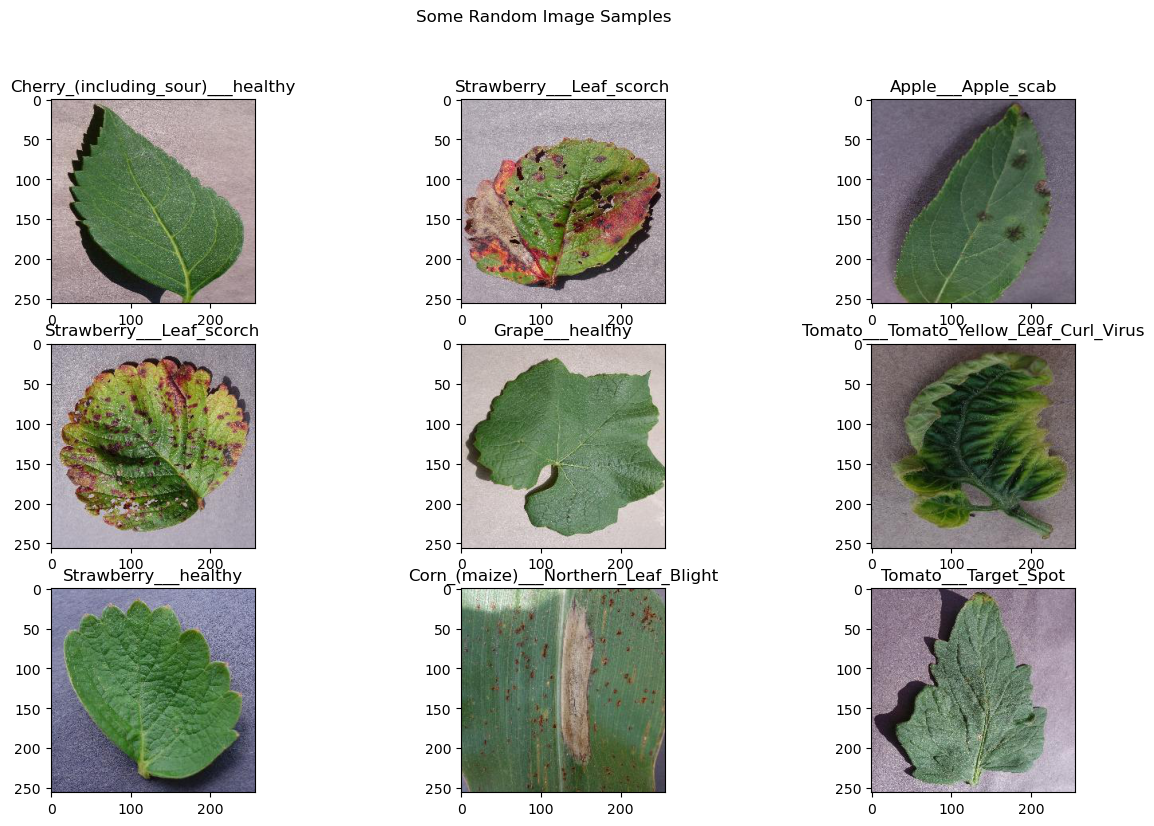

In [8]:
# Vizualize some random images
images = train_val_df.sample(n=9)
fig, ax = plt.subplots(3, 3, figsize=(15, 9))
fig.suptitle('Some Random Image Samples')
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        img = imread(images.iloc[k, 1])
        ax[i][j].imshow(img)
        ax[i][j].set_title(images.iloc[k, 0])


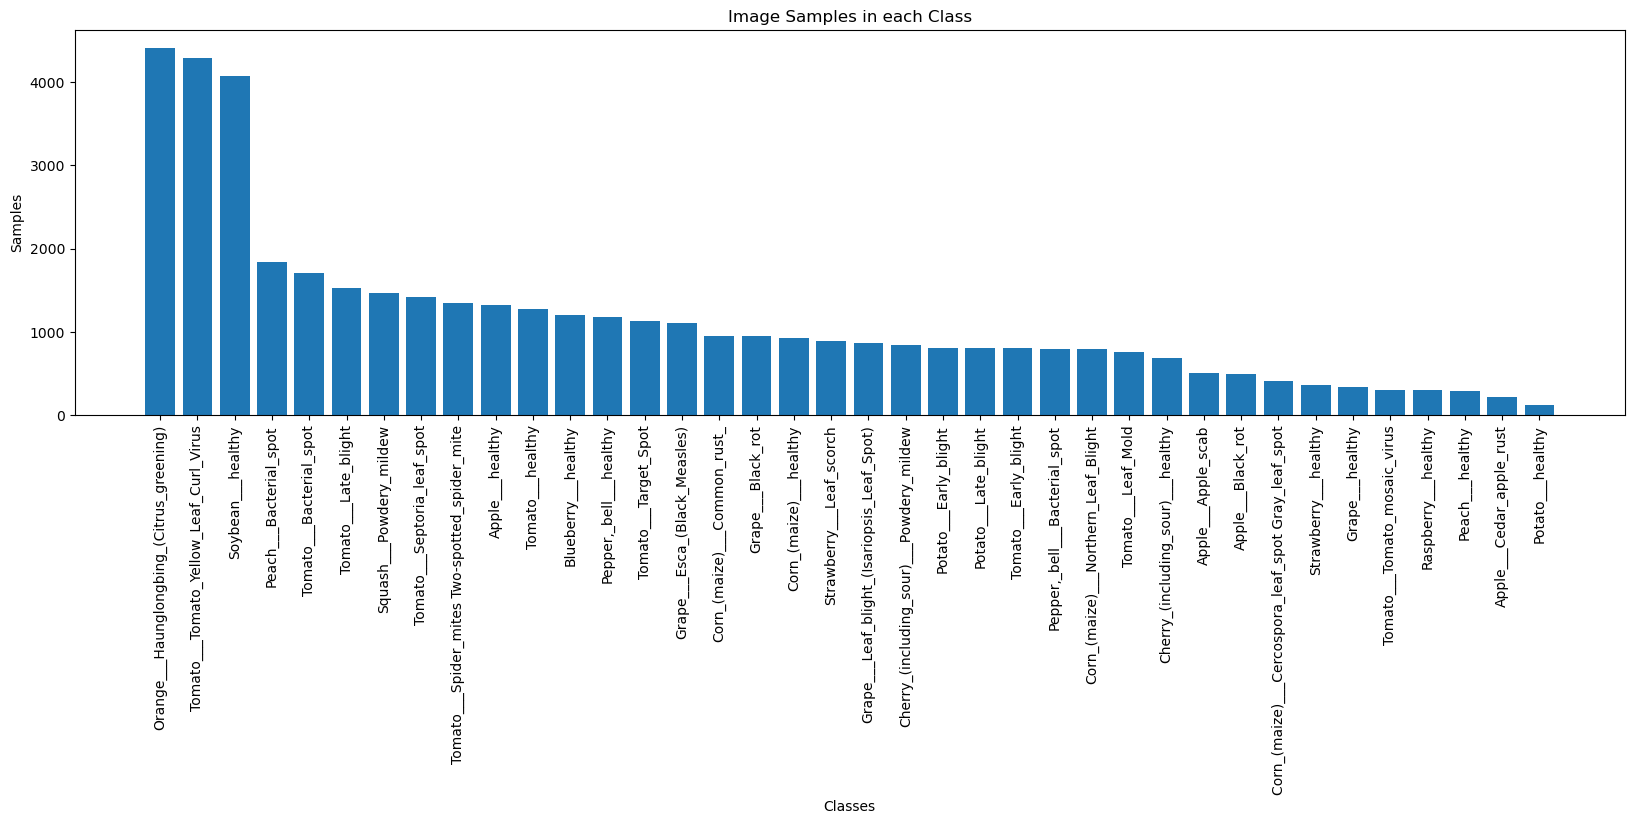

In [9]:
# Vizualize counts of classes
data = train_val_df['label'].value_counts()

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_xlabel('Classes')
ax.set_ylabel('Samples')
ax.set_title('Image Samples in each Class')
ax.bar(data.index, data)
ax.tick_params(axis='x', labelrotation=90)


There is high Class Imbalance

To address this
- Create more Images for classes with less samples using Image Augmentation
- Sample equal number of images from each class for Training Dataset

#### Setting Up Data

In [10]:
# Generating more data by Image Augmentation
path = 'dataset/augmented_dataset'
total_smaples = TRAIN_SAMPLES + VAL_SAMPLES

data_augmentation = tf.keras.Sequential([layers.RandomFlip('horizontal_and_vertical'),
                                         layers.RandomRotation(0.2)])

counts = train_val_df['label'].value_counts()
for label, count in counts.items():
    if count < total_smaples:
        os.makedirs(f'{path}/{label}')

        images = train_val_df[train_val_df['label'] == label]['file_name']
        images = images.apply(lambda x: np.asarray(Image.open(x)))
        images = np.stack(images)
        images = tf.convert_to_tensor(images)

        for i in range(total_smaples//count):
            for j, img in enumerate(images):
                augmented_img = data_augmentation(img)
                augmented_img = Image.fromarray(augmented_img.numpy().astype('uint8'))
                augmented_img.save(f'{path}/{label}/aug{i * count + j}.jpg')


In [11]:
# Adding Augmented Data to Training Data
train_val_df = pd.concat([train_val_df, load_filepaths('dataset/augmented_dataset')], ignore_index=True)


In [12]:
# Sampling Images from each class
total_smaples = TRAIN_SAMPLES + VAL_SAMPLES
train_val_df = train_val_df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=total_smaples))


In [13]:
# Label Encoding
encoder = LabelEncoder().fit(train_val_df['label'].unique())
train_val_df['label'] = encoder.transform(train_val_df['label'])
test_df['label'] = encoder.transform(test_df['label'])

# Saving encoder data for Web Application
enc_file = open('encoder_data.txt', 'w')
for cls in encoder.classes_:
    enc_file.write(re.sub('_+', ' ', cls)+'\n')
enc_file.close()


In [14]:
# Splitting training dataframe into training and validation dataset
train_df = shuffle(train_val_df.groupby('label', group_keys=False).apply(lambda x: x.iloc[:TRAIN_SAMPLES]))
val_df = shuffle(train_val_df.groupby('label', group_keys=False).apply(lambda x: x.iloc[TRAIN_SAMPLES:]))


In [15]:
# Creating Dataset
scaling_layer = layers.Rescaling(1.0/255)
normalizing_layer = layers.Normalization()

ds = tf.data.Dataset.from_tensor_slices((train_val_df['file_name']))
ds = ds.map(lambda x: tf.image.decode_jpeg(tf.io.read_file(x), channels=3), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
ds = ds.map(lambda x: scaling_layer(x), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

normalizing_layer.adapt(ds, batch_size=BATCH_SIZE)


def load_dataframe(df, preprocessing_layers):
    ds = tf.data.Dataset.from_tensor_slices((df['file_name'], df['label']))
    ds = ds.map(lambda x, y: (tf.image.decode_jpeg(tf.io.read_file(x), channels=3), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    ds = ds.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

    for layer in preprocessing_layers:
        ds = ds.map(lambda x, y: (layer(x), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

    # Optimize Performance
    ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds


train_ds = load_dataframe(train_df, [scaling_layer, normalizing_layer])
val_ds = load_dataframe(val_df, [scaling_layer, normalizing_layer])
test_ds = load_dataframe(test_df, [scaling_layer, normalizing_layer])


#### Modelling

In [16]:
# Build Model
input = tf.keras.Input(shape=(256, 256, 3), name='Input_Layer')
output = EfficientNet(input, 1.4, 1.2) # EfficientNet B3

output = layers.BatchNormalization()(output)
output = layers.Dense(256, kernel_regularizer=regularizers.l2(l=0.015), activity_regularizer=regularizers.l1(0.005),
                      bias_regularizer=regularizers.l1(0.005), activation='relu')(output)
output = layers.Dropout(rate=0.45)(output)
output = layers.Dense(38, activation='softmax')(output)

model = Model(inputs=input, outputs=output)

model.compile(Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [17]:
# Training Model
batches = math.ceil(len(train_df)/BATCH_SIZE)

callback = TrainCallback(model, batches, EPOCHS, epoch_patience=2, lr_patience=2)
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=2, callbacks=[callback])


Epoch 1/30
304/304 - 165s - loss: 9.2211 - accuracy: 0.0610 - val_loss: 8.2014 - val_accuracy: 0.0263 - 165s/epoch - 542ms/step
Epoch 2/30
304/304 - 137s - loss: 6.8381 - accuracy: 0.1980 - val_loss: 7.1905 - val_accuracy: 0.0263 - 137s/epoch - 450ms/step
Epoch 3/30
304/304 - 136s - loss: 4.9984 - accuracy: 0.3593 - val_loss: 4.2283 - val_accuracy: 0.4926 - 136s/epoch - 448ms/step
Epoch 4/30
304/304 - 136s - loss: 3.5610 - accuracy: 0.5293 - val_loss: 3.9970 - val_accuracy: 0.4650 - 136s/epoch - 448ms/step
Epoch 5/30
304/304 - 137s - loss: 2.6177 - accuracy: 0.6289 - val_loss: 5.0839 - val_accuracy: 0.6180 - 137s/epoch - 450ms/step
Epoch 6/30
304/304 - 136s - loss: 1.9672 - accuracy: 0.7258 - val_loss: 2.1436 - val_accuracy: 0.7303 - 136s/epoch - 449ms/step
Epoch 7/30
304/304 - 137s - loss: 1.4877 - accuracy: 0.8052 - val_loss: 1.7254 - val_accuracy: 0.7660 - 137s/epoch - 449ms/step
Epoch 8/30
304/304 - 137s - loss: 1.1768 - accuracy: 0.8547 - val_loss: 2.4710 - val_accuracy: 0.7792 - 

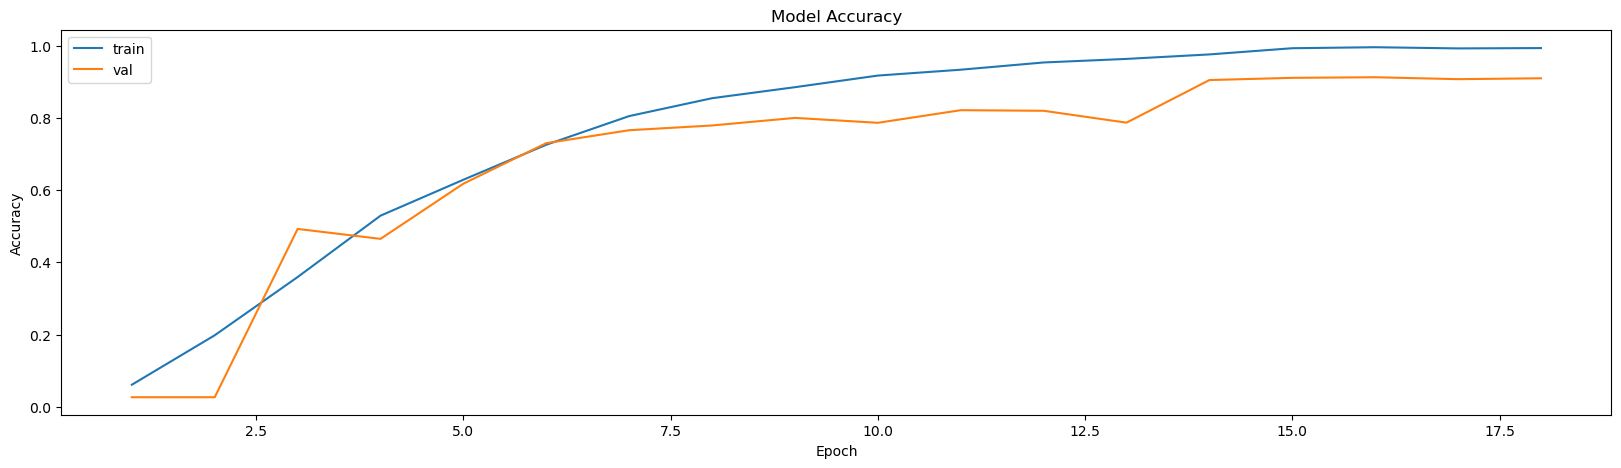

In [18]:
# Plot the training history
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label='train')
ax.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label='val')
_ = ax.legend()

#### Model Evaluation

In [19]:
# Model Accuracy on Test Data
score = model.evaluate(test_ds)
print(f'Accuracy over the test set: {round((score[1]*100), 2)}%')


340/340 [==============================] - 36s 103ms/step - loss: 0.8122 - accuracy: 0.9055
Accuracy over the test set: 90.55%


In [20]:
model.save('model.h5')
